# Workflow for processing Lake George field data

In [1]:
import csv, glob, sys, os, re
from os import listdir
import numpy as np
import pandas as pd
import math as m

import ephem

import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

%matplotlib notebook

import datacube
from datetime import datetime, timedelta
import pyproj
from pandas import Series
import matplotlib.pyplot as plt
import matplotlib
#
# dc will be used later on when comparing with satellite data:
#
dc = datacube.Datacube(app='nbart-fieldsites')

In [2]:
#
# Set up input and output directories etc.
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/12_feb_2018/site_1/'
output = indir+'OUTPUT/'
field_site = 'Lake George'
field_date = '12/2/18'
site_number = 'Site 1'
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'
suffix = 'asd.rad.txt'

#
# Setup based on Emma's code
#
sat_resp = dict({'lsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'lsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'lsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'senti': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/sentinel2a_all.flt'})

# input file
#home2 = '/g/data1a/u46/users/aw3463/GuyByrne/in_spectra/gunning/fr/' 
suffix2 = 'asd.ref.sco.txt'

#
# bad_pans contains the names of individual panels readings that appear to be bogus - they
# read slightly higher than all the other panel readings
#
# bad_grounds contains ground-reading file names that were taken in reflectance mode, so
# cannot be used in this analysis.
#
bad_grounds = ['site_2_p00032.asd.rad', 'site_2_p00033.asd.rad']
#bad_grounds = []
bad_pans = ['site_8_p00000.asd.rad']
#bad_pans = []


#
# Define the first line and spectrum number for all/good/bad panels and grounds
#

firstGoodLine = 2
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2
#firstBadPanelLine = 8
#firstBadPanelSpec= 0

In [3]:
#
# Action functions are defined to retrieve specific parts of the header for each
# spectrum. These functions are used in extract_metadata.
#
def action1(l):
    return l[27:34]

def action2(l):
    #    03/26/2018 at 00:12:58
    #return l[22:26]+"-"+l[16:18]+"-"+l[19:21]+"T"+l[30:38]
    return l[16:38]

def action3(l):
    return l[15:33]

def action4(l):
    return l[15:33]

def action5(l):
    return float(l[17:20])-float(l[20:27])/60

def action6(l):
    return float(l[19:22])+float(l[22:30])/60


#
# Based on action functions defined above, extract header metadata from
# a file.
#
def extract_metadata(filename):
    strings = {
        'instrument number': action1,
        'Spectrum saved': action2,
        'SWIR1 gain': action3,
        'SWIR2 gain': action4,
        'GPS-Latitude': action5,
        'GPS-Longitude': action6
    }
    
    with open(filename) as file:
        list_of_actions = []
        for line in file:
            for search, action in strings.items():
                if search in line:
                    list_of_actions.append(action(line))
        return list_of_actions
                            
#
# Extract header information from a file, as well as the spectrum
# and create a pandas dataframe 'df' that contains all the information.
#
def load_spectrum_to_df(infile, li):
    inst, date_str, swir1_go, swir2_go, lat, lon = extract_metadata(infile)
    #print('SWIR1=', swir1_go)
    swir1_gain = swir1_go[:3]
    swir1_offset = swir1_go[-4:]
    swir2_gain = swir2_go[:3]
    swir2_offset = swir2_go[-4:]

    date_saved = datetime.strptime(date_str, '%m/%d/%Y at %H:%M:%S')
    #date_saved = np.datetime64(date_str)
    #print(date_saved)
    df = pd.read_csv(infile, skiprows=38, delim_whitespace=True)
    filename = df.columns[1]
    df.rename({filename: 'radiance'}, axis=1, inplace=True)
    df['filename'] = filename
    df['date_saved'] = date_saved
    df['Latitude'] = lat
    df['Longitude'] = lon
    df['Line'] = li
    df['Spec_number'] = int(filename[-10:-8])
    df['Inst_number'] = inst
    df['SWIR1_gain'] = swir1_gain
    df['SWIR1_offset'] = swir1_offset
    df['SWIR2_gain'] = swir2_gain
    df['SWIR2_offset'] = swir2_offset
    return df

#
# For each 'line*' directory in 'indir', iterate through each file
# ending with 'suffix' and run 'load_spectrum_to_df'. Finally,
# return a concatenated dataframe made up of all the individual
# dataframes.
#
def load_from_dir(indir):
    all_dfs = []
    for li in range(2, len(glob.glob(indir+'line*'))+1):
        home2 = indir+'line'+str(li)+'/'

        #
        # Initalise 'spectra' list and fill with files that end in 'suffix'
        #
        spectra = []
        for root, dirs, files in sorted(os.walk(home2)):
            for file in files:
                if file.endswith(suffix):
                    spectra.append(file)
        spectra = sorted(spectra)

        for name in spectra:
            infile = home2 + name

            df = load_spectrum_to_df(infile, li)
            all_dfs.append(df)
    return pd.concat(all_dfs)


In [4]:
#
# Define 'alldata' as the dataframe that contains all the raw spectra.
#
#pd.options.display.max_rows = 500
alldata = load_from_dir(indir)
alldata
alldata[alldata['Wavelength']==350]

,Wavelength,radiance,filename,date_saved,Latitude,Longitude,Line,Spec_number,Inst_number,SWIR1_gain,SWIR1_offset,SWIR2_gain,SWIR2_offset
0,350,0.163984,site_2_p00000.asd.rad,2018-02-12 00:26:51,-35.093647,149.462770,2,0,18179/2,87,2068,63,2092
0,350,0.163566,site_2_p00001.asd.rad,2018-02-12 00:26:55,-35.093642,149.462768,2,1,18179/2,87,2068,63,2092
0,350,0.006376,site_2_p00002.asd.rad,2018-02-12 00:27:06,-35.093637,149.462762,2,2,18179/2,87,2068,63,2092
0,350,0.006991,site_2_p00003.asd.rad,2018-02-12 00:27:09,-35.093625,149.462807,2,3,18179/2,87,2068,63,2092
0,350,0.007251,site_2_p00004.asd.rad,2018-02-12 00:27:13,-35.093617,149.462837,2,4,18179/2,87,2068,63,2092
0,350,0.008707,site_2_p00005.asd.rad,2018-02-12 00:27:16,-35.093655,149.462800,2,5,18179/2,87,2068,63,2092
0,350,0.006164,site_2_p00006.asd.rad,2018-02-12 00:27:20,-35.093673,149.462785,2,6,18179/2,87,2068,63,2092
0,350,0.006032,site_2_p00007.asd.rad,2018-02-12 00:27:23,-35.093687,149.462763,2,7,18179/2,87,2068,63,2092
0,350,0.006558,site_2_p00008.asd.rad,2018-02-12 00:27:27,-35.093723,149.462732,2,8,18179/2,87,2068,63,2092
0,350,0.006640,site_2_p00009.asd.rad,2018-02-12 00:27:31,-35.093728,149.462750,2,9,18179/2,87,2068,63,2092


In [5]:
#
# Uncommenting the following line allows jupyter notebook to show more lines.
# This is needed when looking into the details of long dataframes/lists etc.
#
#pd.options.display.max_rows = 5000

#
# Determine panel file names by assuming that all panels have a data value of at least 0.1
# in the first wavelength (350nm). Call this dataframe 'panel_names'.
#
panel_names = alldata[(alldata['Wavelength']==350) & (alldata['radiance']>=0.1)]['filename']

#
# Create the following dataframes:
#
# good_panels = all panel data with bad panels removed
# bad_panels  = all bad panel data
# all_panels = both good and bad panel data
#
all_panels = alldata.loc[alldata['filename'].isin(panel_names)]
good_panels = all_panels.loc[~all_panels['filename'].isin(bad_pans)]
bad_panels = alldata.loc[alldata['filename'].isin(bad_pans)]

#
# Create 'good_grounds', which is the dataframe that contains all the ground
# readings, except for any bad ground data (bad_grounds - defined in the 2nd
# cell). Also create all_grounds for all ground data.
#
tmp_grounds = alldata.loc[~alldata['filename'].isin(bad_grounds)]
good_grounds = tmp_grounds.loc[~tmp_grounds['filename'].isin(panel_names)]
all_grounds = alldata.loc[~alldata['filename'].isin(panel_names)]
#
# Saving commented out code that allows you to print out all the file names
# in good_grounds.
#
#tt = good_grounds[['Wavelength', 'filename']]
#print(tt.loc[tt['Wavelength']==350])


In [6]:
#
# Loop over each line 'i' and then over each spectrum 'j' within line 'i'.
# For the first spectrum (line=firstline, spec=firstspec), copy both the
# Wavelength (for the index) and radiance to a new dataframe (temp2).
# For all subsequent spectra, append the new dataframe with a radiance
# column. The results in a new dataframe 'outpanel' that has a wavelength
# column (also set as the index), plus all the radiances in subsequent
# columns.
#
def make_spec_df(in_df):
    for i in in_df.Line.unique():
        temp_loop = in_df[(in_df['Wavelength']==350) & (in_df['Line']==i)]
        for j in temp_loop['Spec_number']:
            temp2 = in_df[(in_df['Spec_number']==j) & (in_df['Line']==i)]
            
            try:
                out_df['radiance'+str(i)+"-"+str(j)] = temp2['radiance']
            except UnboundLocalError:
                out_df = temp2[['Wavelength', 'radiance']].copy()

    out_df.set_index("Wavelength", inplace=True)

    return out_df
  
all_panel_spec = make_spec_df(all_panels)
good_panel_spec = make_spec_df(good_panels)
try:
    bad_panel_spec = make_spec_df(bad_panels)
except UnboundLocalError:
    pass


<IPython.core.display.Javascript object>


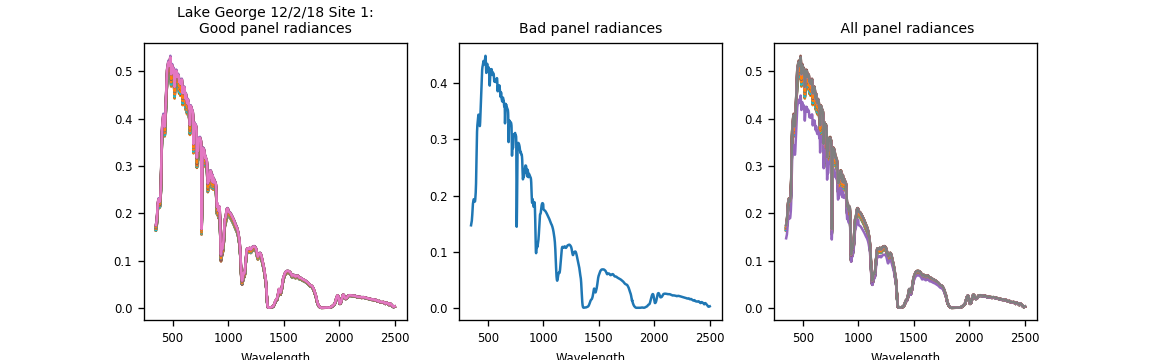

In [7]:
matplotlib.rcParams.update({'font.size': 7})
#
# Plot the radiances for the good panels.
#
jstest = good_panel_spec.copy()

fig, axes = plt.subplots(nrows=1, ncols=3)

jstest.plot(title = field_site+" "+field_date+" "+site_number+":\nGood panel radiances", legend=False, ax=axes[0], figsize=(9.6, 3.0))

#
# Plot the bad panel radiances (found in line 8)
#
try:
    jstest2 = bad_panel_spec.copy()
    jstest2.plot(title = "Bad panel radiances", legend=False, ax=axes[1])
except NameError:
    pass
#
# Plot the ALL panel radiances
#
jstest2b = all_panel_spec.copy()
jstest2b.plot(title = " All panel radiances", legend=False, ax=axes[2])

directory = os.path.dirname(output)
if not os.path.exists(directory):
    os.makedirs(directory)

plt.savefig(output+'Fig01_PanelRadiances.png')

<IPython.core.display.Javascript object>


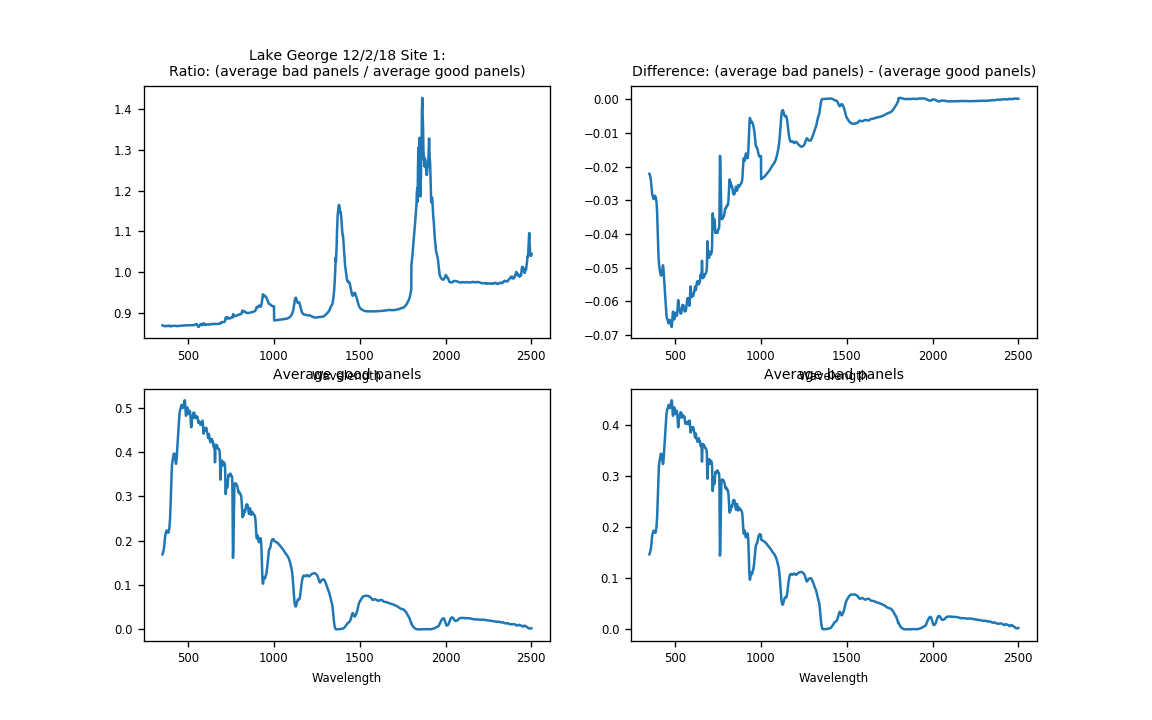

In [8]:
#
# Create a mean of the good panel readings, as well as the bad panel
# readings. Then a ratio and a difference of the two can be (seperately)
# created and plotted.
#
# Since the two bad panel readings are higher than they should be, we
# put the bad panels on the top of the division and first in the
# difference.
#

good_panel_mean = good_panel_spec.mean(axis=1)
try: 
    bad_panel_mean = bad_panel_spec.mean(axis=1)
    good_bad_div = bad_panel_mean.div(good_panel_mean, axis=0)
    good_bad_diff = bad_panel_mean.sub(good_panel_mean, axis=0)

    pd.Series.to_frame(good_bad_div)
    pd.Series.to_frame(good_bad_diff)

    fig, axes = plt.subplots(nrows=2, ncols=2)

    #jstest3a = pd.concat([waves, good_bad_div], axis=1)
    #good_bad_div.set_index("Wavelength", inplace=True)
    good_bad_div.plot(title=field_site+" "+field_date+" "+site_number+':\nRatio: (average bad panels / average good panels)', legend=False, ax=axes[0,0], figsize=(9.6, 6.0))

    #jstest3b = pd.concat([waves, good_bad_diff], axis=1)
    #good_bad_diff.set_index("Wavelength", inplace=True)
    good_bad_diff.plot(title='Difference: (average bad panels) - (average good panels)', legend=False, ax=axes[0,1])

    #jstest3c = pd.concat([waves, good_panel_mean], axis=1)
    #good_panel_mean.set_index("Wavelength", inplace=True)
    good_panel_mean.plot(title='Average good panels', legend=False, ax=axes[1,0])

    #jstest3c = pd.concat([waves, bad_panel_mean], axis=1)
    #bad_panel_mean.set_index("Wavelength", inplace=True)
    bad_panel_mean.plot(title='Average bad panels', legend=False, ax=axes[1,1])
    plt.savefig(output+'Fig02_GoodBadPanelCompare.png')

except NameError:
    pass

<IPython.core.display.Javascript object>


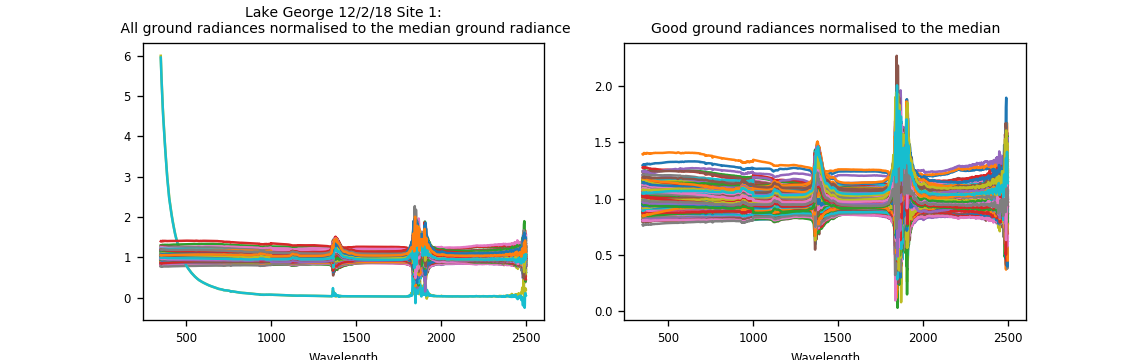

In [9]:
#good_grounds.set_index("Wavelength", inplace=True)
#
# Loop over all spectra in 'good_grounds' to produce a dataframe that
# has 'Wavelength' as the first column and radiances for all the good
# grounds in subsequent columns: 'good_grounds_spec'.
#
good_grounds_spec = make_spec_df(good_grounds)
#for i in [2,3,4,6,7,8]:
#    temp_loop = good_grounds[(good_grounds['Wavelength']==350) & (good_grounds['Line']==i)]
#    for j in temp_loop['Spec_number']:
#        temp2 = good_grounds[(good_grounds['Spec_number']==j) & (good_grounds['Line']==i)]
#        if i==2 and j==2:
#            good_grounds_spec = temp2[['Wavelength', 'radiance']].copy()
#        else:
#            good_grounds_spec['radiance'+str(i)+"-"+str(j)] = temp2['radiance']

# Set 'Wavelength' as the index for the dataframe
#good_grounds_spec.set_index("Wavelength", inplace=True)

#
# Loop over all spectra in 'all_grounds' to produce a dataframe that
# has 'Wavelength' as the first column and radiances for all the
# grounds in subsequent columns: 'all_grounds_spec'.
#
all_grounds_spec = make_spec_df(all_grounds)

#for i in [2,3,4,6,7,8]:
#    temp_loop = all_grounds[(all_grounds['Wavelength']==350) & (all_grounds['Line']==i)]
#    for j in temp_loop['Spec_number']:
#        temp2 = all_grounds[(all_grounds['Spec_number']==j) & (all_grounds['Line']==i)]
#        if i==2 and j==2:
#            all_grounds_spec = temp2[['Wavelength', 'radiance']].copy()
#        else:
#            all_grounds_spec['radiance'+str(i)+"-"+str(j)] = temp2['radiance']

# Set 'Wavelength' as the index for the dataframe
#all_grounds_spec.set_index("Wavelength", inplace=True)

#
# Create a median of all the good_grounds spectra and use this to
# normalise the good_grounds spectra. Then plot the result.
#
good_median = good_grounds_spec.median(axis=1)
good_norm = good_grounds_spec.div(good_median, axis=0)
all_norm = all_grounds_spec.div(good_median, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2)

jstest4 = all_norm.copy()
jstest4.plot(title=field_site+" "+field_date+" "+site_number+":\n \
All ground radiances normalised to the median ground radiance", legend=False, ax=axes[0], figsize=(9.5, 3.0))

jstest5 = good_norm.copy()
jstest5.plot(title="Good ground radiances normalised to the median", legend=False, ax=axes[1])
plt.savefig(output+'Fig03_GroundRadiances.png')



<IPython.core.display.Javascript object>


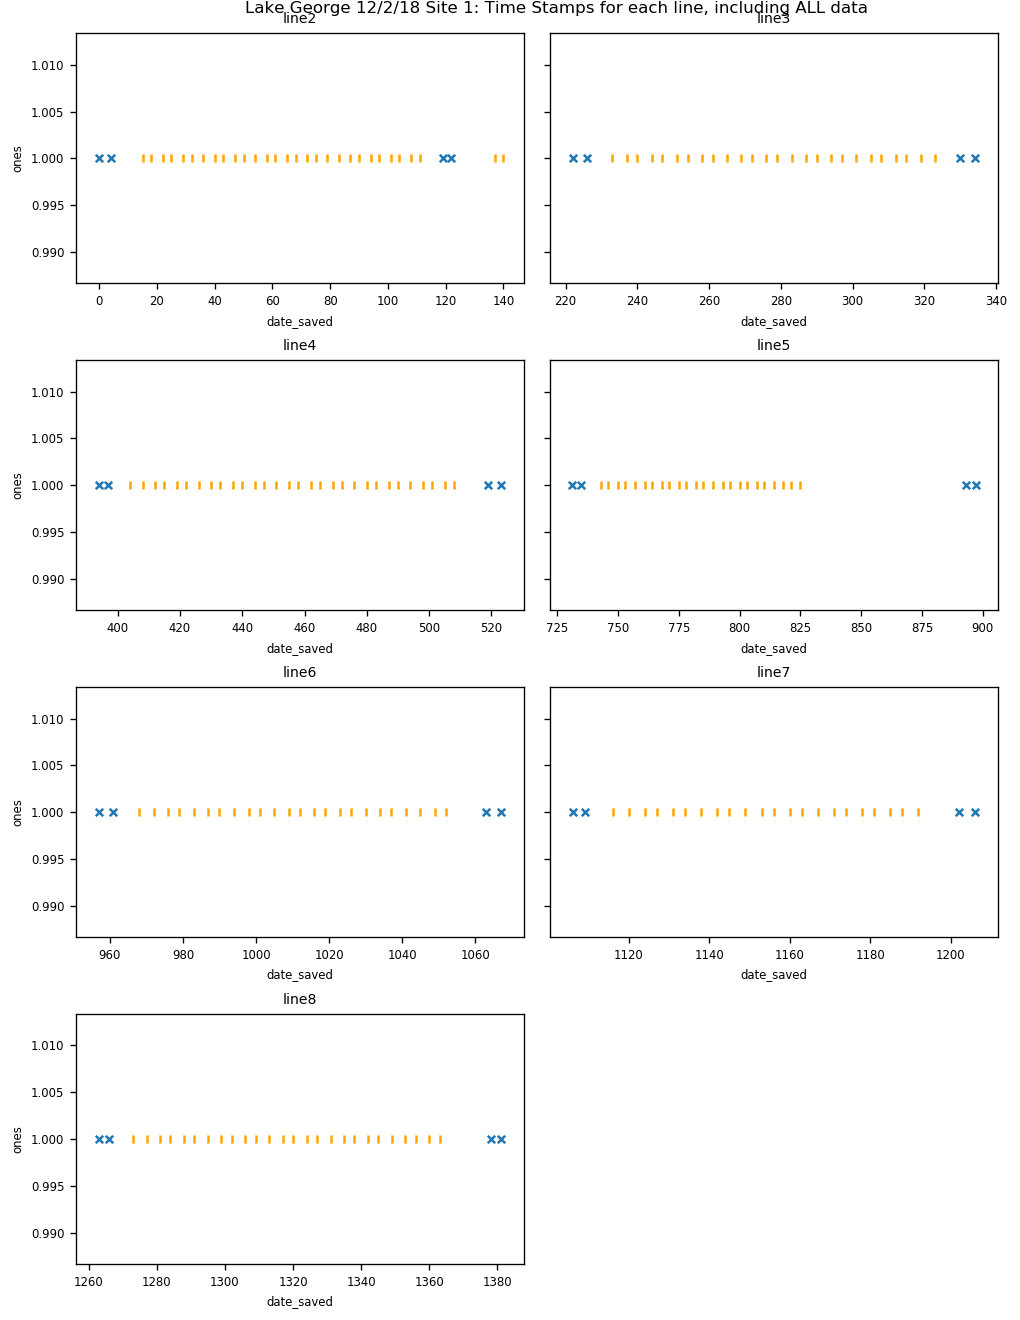

In [10]:
matplotlib.rcParams.update({'font.size': 7})

#
# Make a new dataframe with time since the first good panel reading
# along the x-axis and "1" for the y-axis. This allows a plot of the
# data timeline to be made.
#
def make_timeline(in_df, good_panels):
    
    temp_df = in_df[['date_saved', 'Line']].loc[in_df['Wavelength']==350]
    gpt = good_panels[['date_saved', 'Line']].loc[good_panels['Wavelength']==350]
    
    out_df = temp_df.copy()
    for i in range(len(out_df)):
        out_df.iloc[[i], [0]]=(temp_df.iloc[i][0]-gpt.iloc[0][0]).seconds

    out_df['ones'] = np.ones(len(out_df))
    return out_df

gpt2 = make_timeline(good_panels, good_panels)
gpt2a = make_timeline(all_panels, good_panels)
adt2 = make_timeline(good_grounds, good_panels)
adt2a = make_timeline(all_grounds, good_panels)



# DO PLOTS FOR ALL DATA FIRST - difference in the bork.
#
# Make a 3x3 plot of each line, showing times from the start in seconds.
# Panel readings are coded in as blue crosses and ground readings are
# coded as orange vertical lines.
#
def panel_plot_layout(nlines):
    n=3; m=5
    if nlines < 13:
        m=4
    if nlines < 10:
        m=3
    if nlines < 9:
        n=2; m=4
    if nlines < 7:
        m=3
    if nlines < 5:
        m=2
    if nlines < 3:
        m=1
    if nlines < 2:
        n=1
    return n, m


def multi_timeline_plot(gpt2a, adt2a):
    n, m = panel_plot_layout(len(gpt2a.Line.unique()))
    fig, axes = plt.subplots(nrows=m, ncols=n)

    k=1
    for i in range(m):
        for j in range(n):
            k+=1
            if k>len(gpt2a.Line.unique())+1:
                break
            else:
                temp_loop = gpt2a[(gpt2a['Line']==k)]
                all_loop = adt2a[(adt2a['Line']==k)]
                all_loop.plot(x='date_saved', y='ones', kind='scatter', legend=False, ax=axes[i,j], color='orange', marker='|', figsize=(8.5, 11))
                temp_loop.plot(x='date_saved', y='ones', kind='scatter', legend=False, ax=axes[i,j], marker='x', sharey=True, title='line'+str(k))

    if k in [1, 3, 5, 8, 9, 11, 12]:
        axes[-1, -1].axis('off')
    if k in [10, 13]:
        axes[-2, -2].axis('off')
    plt.tight_layout()
    matplotlib.rcParams.update({'font.size': 7})
    #plt.scatter(2465, 1.007, marker="|", c='orange')
    #plt.scatter(2465, 1.009, marker="x", c='blue')
    #plt.figtext(0.915, 0.268, "Panel")
    #plt.figtext(0.912, 0.246, "Ground")

    
multi_timeline_plot(gpt2a, adt2a)

matplotlib.rcParams.update({'font.size': 10})
plt.figtext(0.24, 0.99, field_site+" "+field_date+" "+site_number+': Time Stamps for each line, including ALL data')
matplotlib.rcParams.update({'font.size': 7})
plt.savefig(output+'Fig04_AllTimeLineData.png')

<IPython.core.display.Javascript object>


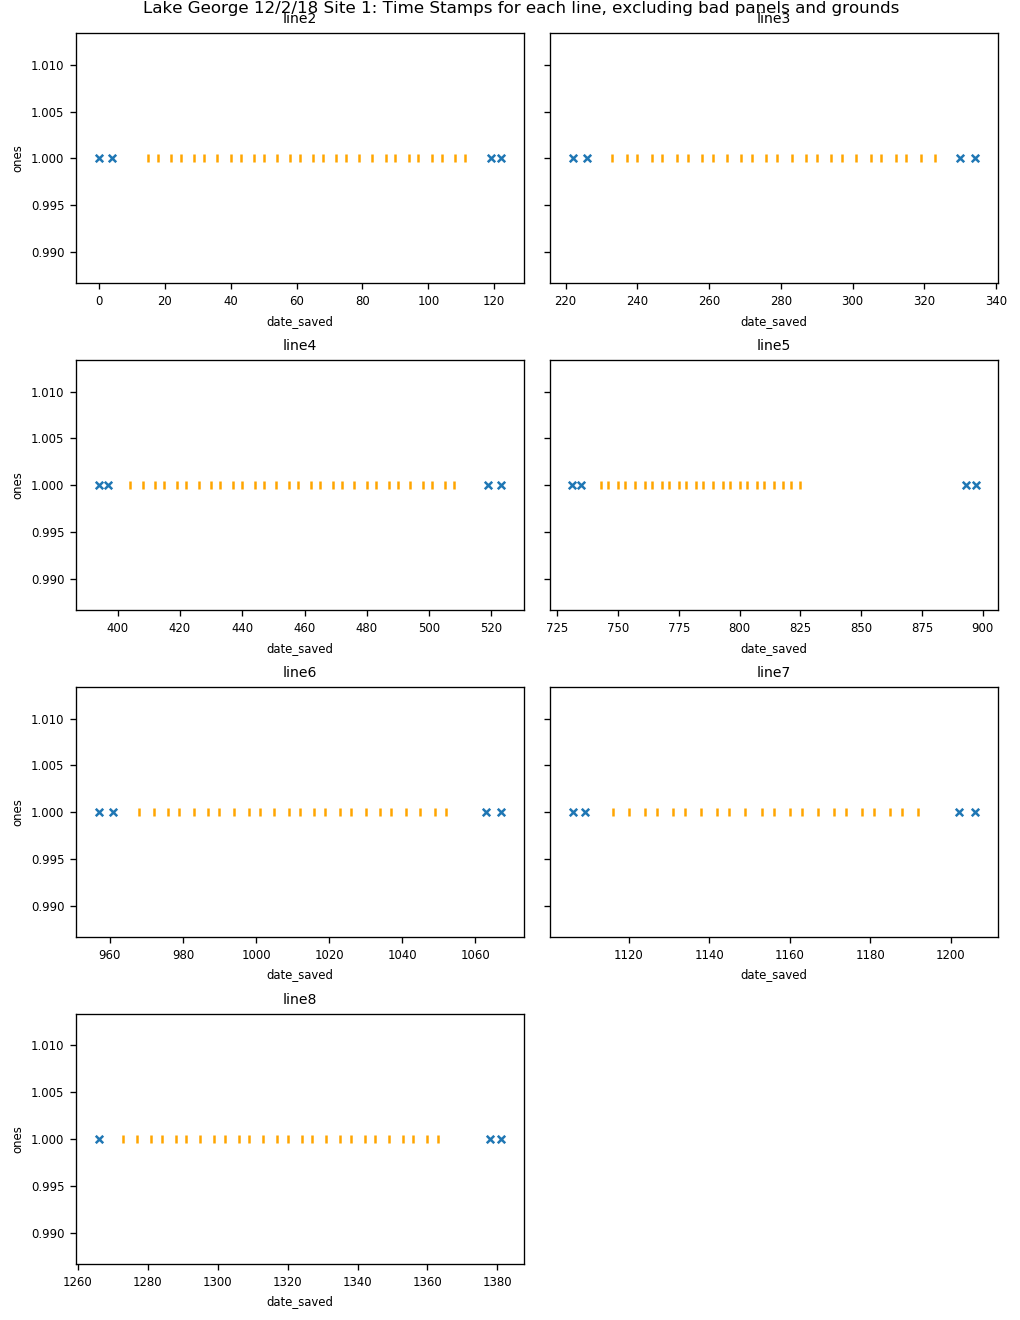

In [11]:
# REDO PLOT FOR JUST GOOD DATA
# Make a 3x3 plot of each line, showing times from the start in seconds.
# Panel readings are coded in as blue crosses and ground readings are
# coded as orange vertical lines.
#
multi_timeline_plot(gpt2, adt2)

matplotlib.rcParams.update({'font.size': 10})
plt.figtext(0.14, 0.99, field_site+" "+field_date+" "+site_number+': Time Stamps for each line, excluding bad panels and grounds')
plt.savefig(output+'Fig05_GoodTimeLineData.png')

<IPython.core.display.Javascript object>


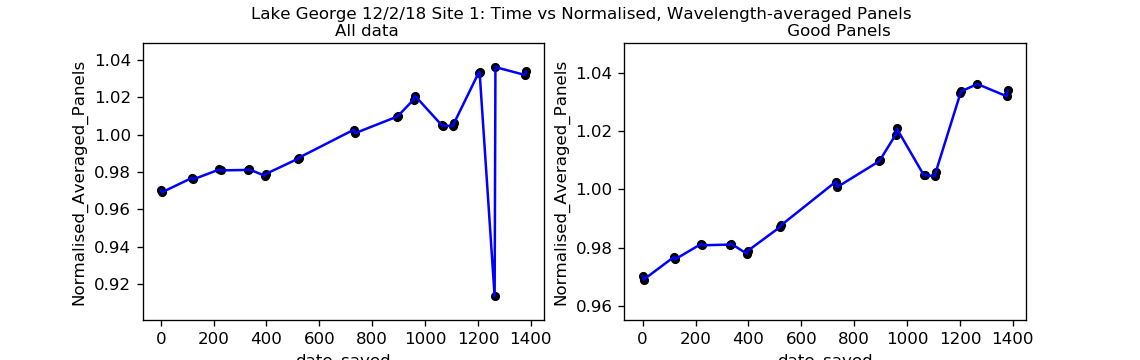

In [12]:
#good_panel_mean.set_index("Wavelength", inplace=True)
good_norm_panels = good_panel_spec.div(good_panel_mean, axis=0)
all_norm_panels = all_panel_spec.div(good_panel_mean, axis=0)
#norm_panels.plot(legend=False)

#
# Create a mask to avoid wavelengths where atmospheric transmission is
# close to zero: 1350-1480nm, 1801-1966nm and >2350nm
#
mask1 = good_panel_mean.where(np.logical_or(good_panel_mean.index<1350, good_panel_mean.index>1480))
mask2 = mask1.where(np.logical_or(mask1.index<1801, mask1.index>1966))
mean_panel_masked = mask2.where(np.logical_or(mask2.index<2350, mask2.index>2500))

#
# The follwing line will create an extreme mask, including only wavelengths
# between 1600 and 1700nm.
#
#median_panel_masked = median_panel.where(np.logical_and(mask2.index<1700, mask2.index>1600))

good_norm_panels_masked = good_panel_spec.div(mean_panel_masked, axis=0)
all_norm_panels_masked = all_panel_spec.div(mean_panel_masked, axis=0)
good_averages_masked = good_norm_panels_masked.mean(axis=0)
all_averages_masked = all_norm_panels_masked.mean(axis=0)


gpt2['Normalised_Averaged_Panels']=good_averages_masked.values
gpt2a['Normalised_Averaged_Panels']=all_averages_masked.values

fig, axes = plt.subplots(nrows=1, ncols=2)

gpt2a.plot.scatter(x='date_saved', y='Normalised_Averaged_Panels', color='black', ax=axes[0])
gpt2a.plot.line(x='date_saved', y='Normalised_Averaged_Panels', ax=axes[0], style='b', legend=False, figsize=(9.5, 3.0))

gpt2.plot.scatter(x='date_saved', y='Normalised_Averaged_Panels', color='black', ax=axes[1])
gpt2.plot.line(x='date_saved', y='Normalised_Averaged_Panels', ax=axes[1], style='b', legend=False)

matplotlib.rcParams.update({'font.size': 10})
plt.figtext(0.22, 0.9, field_site+" "+field_date+" "+site_number+': Time vs Normalised, Wavelength-averaged Panels\n                All data                                                                          Good Panels')
matplotlib.rcParams.update({'font.size': 7})
plt.savefig(output+'Fig06_TimevsAvgPanels.png')

<IPython.core.display.Javascript object>


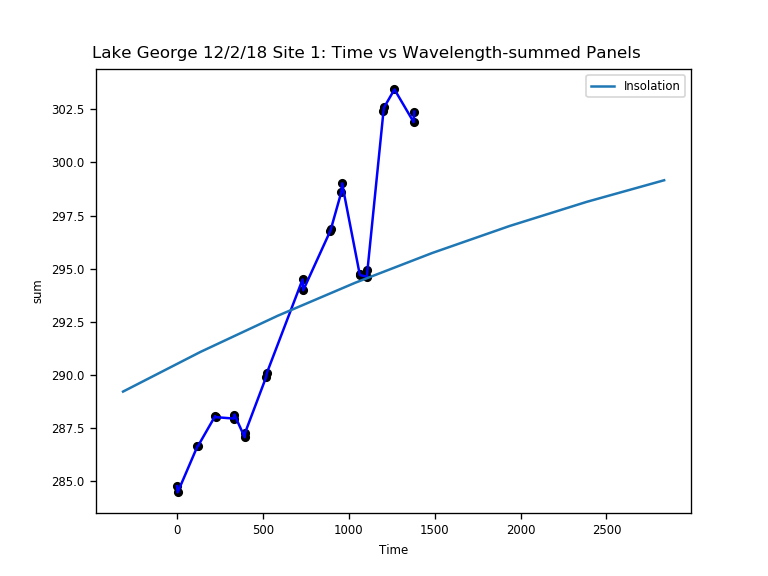

In [13]:
good_panel_spec.sum(axis=0)
gpt2['sum']=good_panel_spec.sum(axis=0).values

ax2 = gpt2.plot.scatter(x='date_saved', y='sum', color='black')
gpt2.plot.line(x='date_saved', y='sum', ax=ax2, style='b', legend=False)
matplotlib.rcParams.update({'font.size': 10})
plt.figtext(0.12, 0.9, field_site+" "+field_date+" "+site_number+': Time vs Wavelength-summed Panels')
matplotlib.rcParams.update({'font.size': 7})


#
# The Following dataframe assumes 26/3/2018, where meridian is at 02:07:44 (UTC) and
# that t=0 is 00:12:58, which is the UTC date stamp of the first panel reading. This dataframe
# then gives the Insolation values, as a function of seconds.
#
sdf_dst = pd.DataFrame([[-314.0, 0.9544765503230449], [136.0, 0.960635398038314], [586.0, 0.9662590390482365],
                        [1036.0, 0.9713789520297165], [1486.0, 0.9760229720710379], [1936.0, 0.9802156732739963],
                        [2386.0, 0.9839786952371856], [2836.0, 0.9873310215393157]], columns=['Time', 'Insolation'])
#
# The following plot shows the same increase in panel readins, as above, but this time, two lines for
# Insolation are plotted. The blue line shows a scaled Insolation curve. The data *should* fit this curve,
# but they do not, without re-aligning the y-axis, as shown in the orange curve. The orange curve is a good
# fit to the data, but it no longer follows the Insolation curve for the time of day.
#
# The reason for this discrepancy may be because the atmospheric absorption is not taken into account. If it
# were, then this should have the effect of steepening the Insolation curve as there is more atmospheric
# absorption when the Sun is lower in the sky (earlier in the day).
#
sdf_dst_fixed = sdf_dst.copy()

sdf_dst['Insolation']*=303
sdf_dst.plot.line(x='Time', y='Insolation', ax=ax2)

###sdf_dst_fixed['Insolation']-=0.73
###sdf_dst_fixed['Insolation']*=989
###sdf_dst_fixed.plot.line(x='Time', y='Insolation', ax=ax2)
plt.savefig(output+'Fig07_TimevsAvgPanelsInsolation.png')

In [14]:
def k_factor(panel_dir, in_panel):
    #
    # Read in k-factor from csv file and add 'wavelength' label
    #
    k_f = pd.read_csv(panel_dir + in_panel, skiprows=5, delim_whitespace=True)
    # Set index to wavelength
    k_f.set_index("Wavelength", inplace = True) 
    
    return k_f

<IPython.core.display.Javascript object>


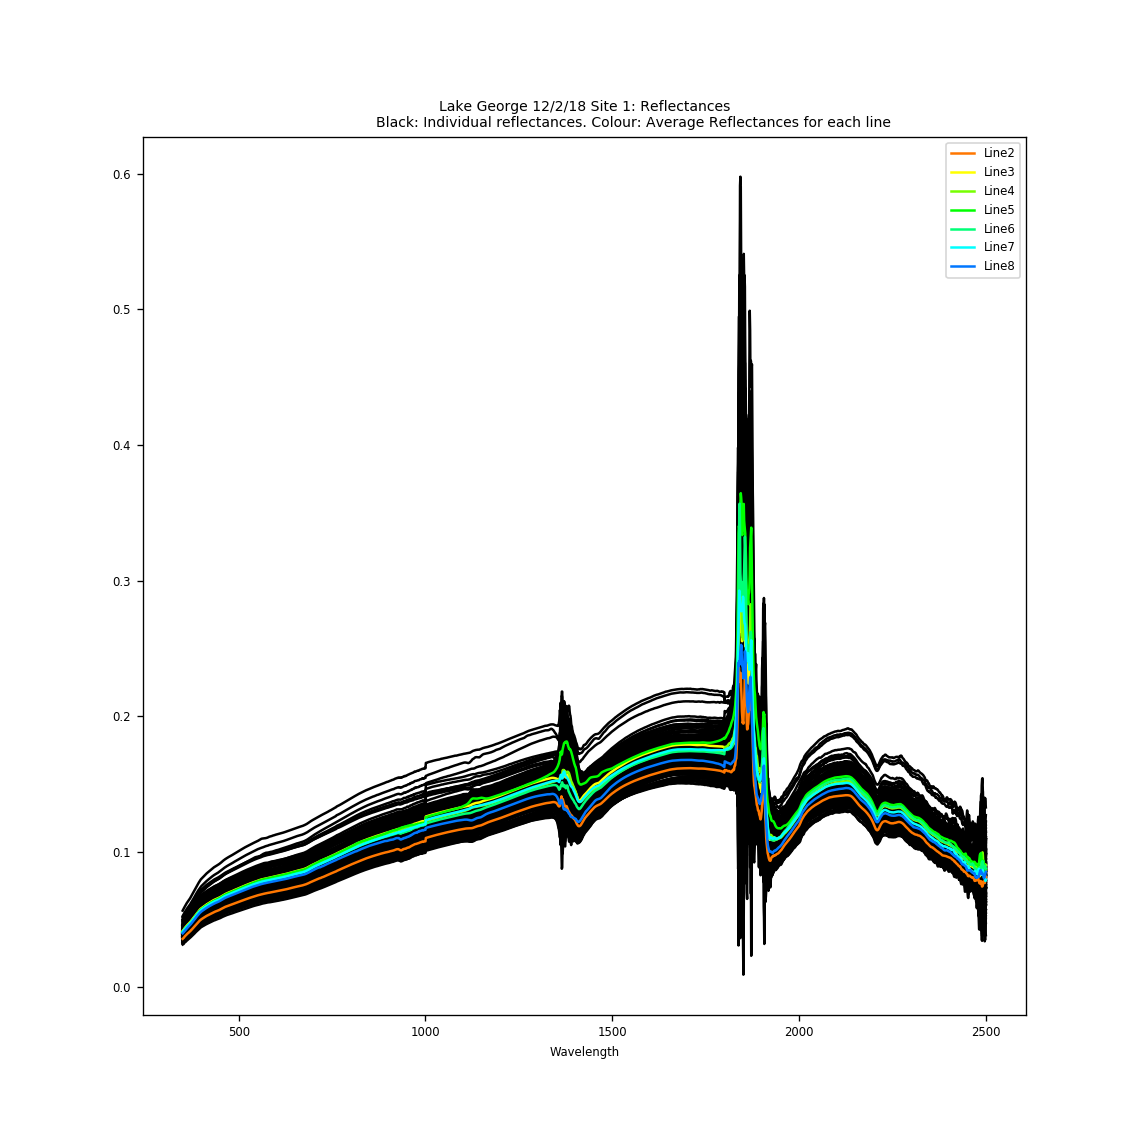

In [15]:
k_f = k_factor(panel_dir, in_panel)

gps_new_name = 'radiance'+str(firstGoodLine)+"-"+str(firstGoodPanelSpec)
ggs_new_name = 'radiance'+str(firstGoodLine)+"-"+str(firstGoodGroundSpec)
good_panel_spec.rename(columns={'radiance': gps_new_name}, inplace=True)

good_grounds_spec.rename(columns={'radiance': ggs_new_name}, inplace=True)
#good_grounds_spec

frames = []
for j in good_panels.Line.unique():
    line_name_pans = [col for col in good_panel_spec.columns if 'radiance'+str(j) in col]
    
    tmplist = []
    k = 0
    for i in line_name_pans:
        temp = good_panel_spec[i]
        tmplist.append(temp)
    
    tmp_df = pd.concat(tmplist, axis=1)
    line_avg_panel = tmp_df.mean(axis=1)
    
    line_name_grounds = [col for col in good_grounds_spec.columns if 'radiance'+str(j) in col]
    
    tmplist = []
    k = 0
    for i in line_name_grounds:
        temp = good_grounds_spec[i]
        tmplist.append(temp)
    
    tmp_df = pd.concat(tmplist, axis=1)
    refl_tmp = tmp_df.div(line_avg_panel, axis=0)
    
    #Multiply by k-factor
    #line_refls = refl_tmp.mul(k_f, axis=0)
    line_refls = pd.np.multiply(refl_tmp, k_f)
    
    frames.append(line_refls)
all_refls = pd.concat(frames, axis=1)

axy = all_refls.plot(legend=False, title=field_site+" "+field_date+" "+site_number+': Reflectances\n \
                     Black: Individual reflectances. Colour: Average Reflectances for each line',
                     figsize=(9.5, 9.5), color='k')

colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077']

for i in good_panels.Line.unique():
    rad_name = 'radiance'+str(i)
    line = all_refls.filter(like=rad_name).mean(axis=1)
    line.plot(ax=axy, color=colpac[i], legend=True, label='Line'+str(i))
    
plt.savefig(output+'Fig08_Reflectances.png')

In [16]:
def get_spectrum_curve(f_name):
    band_n = dict() 
    key = list()
    wavelength = np.array([], dtype='float64') 
    response = np.array([], dtype='float64') 
    with open(f_name, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ', skipinitialspace=True)
        for row in csv_reader:
            if row[0].lower().find('band') >= 0:
                key.append(row[0].lower()+row[1])
                if wavelength.shape[0] > 0:
                    spectrum_curve = np.vstack([wavelength, response]).T
                    band_n.update({key[len(key)-2]: spectrum_curve})
                    wavelength = np.array([], dtype='float64') 
                    response = np.array([], dtype='float64') 
            else:
                wavelength = np.append(wavelength, float(row[0]))
                response = np.append(response, float(row[1]))
    spectrum_curve = np.vstack([wavelength, response]).T
    band_n.update({key[len(key)-1]: spectrum_curve})
    wavelength = np.array([], dtype='float64') 
    response = np.array([], dtype='float64') 
    return band_n 

In [17]:
def field_int_curve(field_data, band):
    result = np.zeros(len(band))
    i = 0
    for b in band:
        spectrum_curve = band[b]
        dom_a = max(min(spectrum_curve[:, 0]), min(field_data[:, 0]))
        dom_b = min(max(spectrum_curve[:, 0]), max(field_data[:, 0]))
        source_x = field_data[:, 1][np.where((field_data[:, 0] >= dom_a) & 
                (field_data[:, 0] <= dom_b))]
        source_y = spectrum_curve[:, 1][np.where((spectrum_curve[:, 0] >= dom_a) & 
            (spectrum_curve[:, 0] <= dom_b))]
        result[i] = sum(source_x*source_y)/sum(source_y)
        i += 1
    return result

In [18]:
f_name = sat_resp['lsat8']
band = get_spectrum_curve(f_name)
result = []
field_data = all_refls
wave_length = np.array(all_refls.index, dtype='float64')
for col in field_data.columns:
    source_x = np.vstack([wave_length, np.array(field_data[col], dtype='float64')]).T
    result.append(field_int_curve(source_x, band))
result_df = pd.DataFrame(result)
result_df.columns = list(band.keys())


<IPython.core.display.Javascript object>


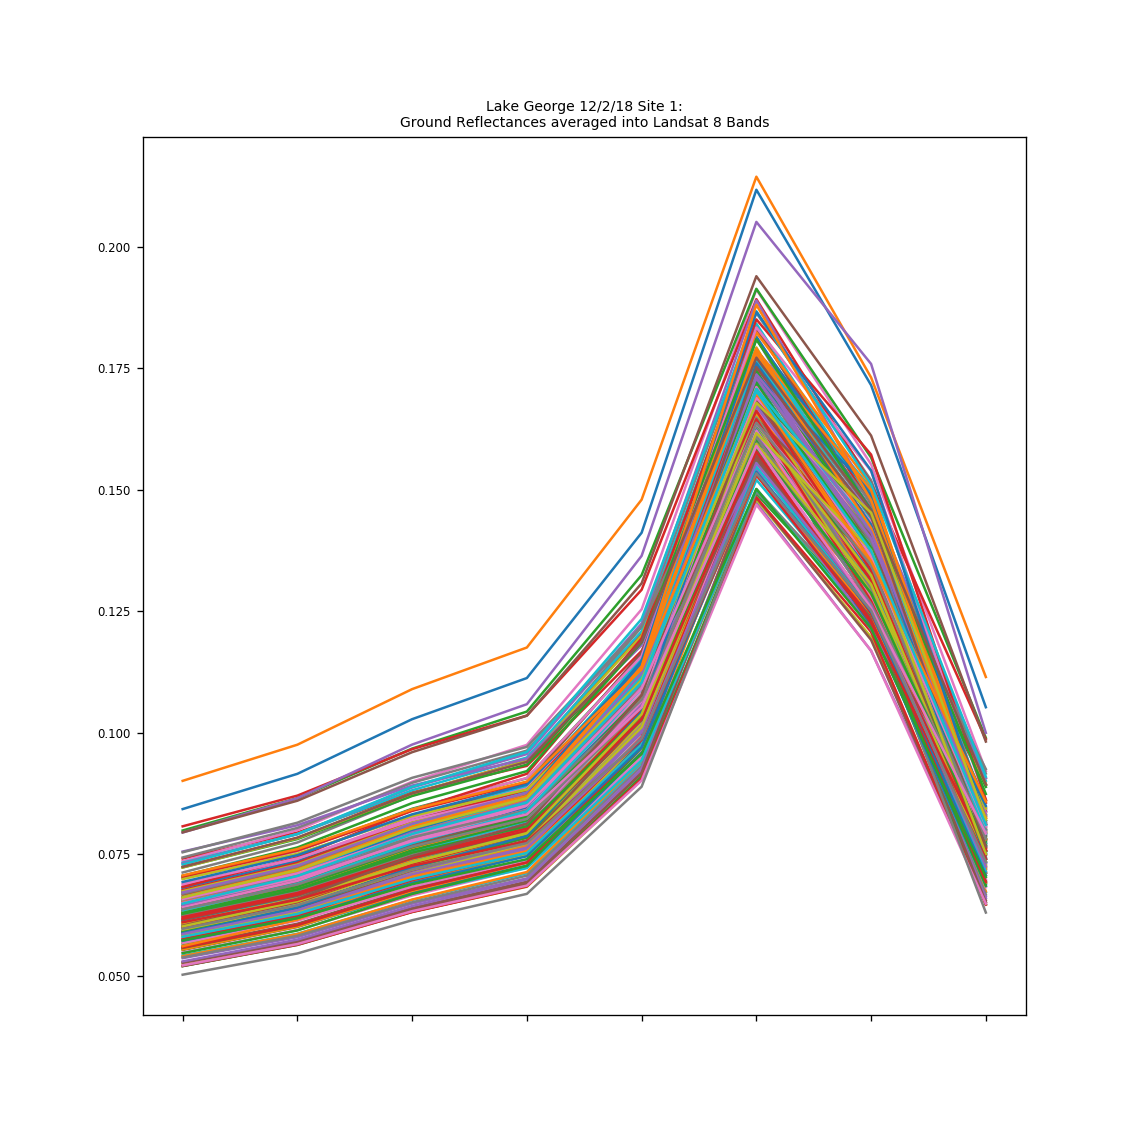

In [19]:
result_df.T.plot(legend=False, title=field_site+" "+field_date+" "+site_number+':\nGround Reflectances averaged into Landsat 8 Bands', figsize=(9.5, 9.5))
plt.savefig(output+'Fig09_BandReflectances.png')

In [20]:
gg = good_grounds[(good_grounds['Wavelength']==350)]
gg.reset_index(drop=True, inplace=True)

catty = pd.concat([gg,result_df], axis=1)
ground_bands = catty.drop(['Wavelength', 'radiance'], axis=1)

In [21]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'], format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

ground_bands['Solar_angle'] = ground_bands.apply(solar_angle, axis=1)
ground_bands

#
# The following allows you to test the Solar zenith angle for various times on a given day.
# This is useful to find the Solar meridian.
#
#pdata = np.array([['', 'Longitude', 'Latitude', 'date_saved'],
#                      ['band0', 149.461428, -35.093030, datetime(2018,3,26,2,7,40)],
#                      ['band1', 149.461428, -35.093030, datetime(2018,3,26,2,7,42)],
#                      ['band2', 149.461428, -35.093030, datetime(2018,3,26,2,7,44)],
#                      ['band2', 149.461428, -35.093030, datetime(2018,3,26,2,8,46)],
#                      ['band2', 149.461428, -35.093030, datetime(2018,3,26,2,9,48)],
#                      ])
#
#pdf = pd.DataFrame(data=pdata[1:,1:],
#              index=pdata[1:,0],
#              columns=pdata[0,1:])
#pdf['Solar_angle'] = pdf.apply(solar_angle, axis=1)
#pdf



,filename,date_saved,Latitude,Longitude,Line,Spec_number,Inst_number,SWIR1_gain,SWIR1_offset,SWIR2_gain,SWIR2_offset,band1,band2,band3,band4,band5,band6,band7,band8,Solar_angle
0,site_2_p00002.asd.rad,2018-02-12 00:27:06,-35.093637,149.462762,2,2,18179/2,87,2068,63,2092,0.056600,0.061514,0.069330,0.075600,0.100461,0.164689,0.130993,0.071168,32.545942
1,site_2_p00003.asd.rad,2018-02-12 00:27:09,-35.093625,149.462807,2,3,18179/2,87,2068,63,2092,0.062079,0.067578,0.076151,0.082670,0.107625,0.167842,0.128966,0.078057,32.537441
2,site_2_p00004.asd.rad,2018-02-12 00:27:13,-35.093617,149.462837,2,4,18179/2,87,2068,63,2092,0.063131,0.068206,0.076236,0.081955,0.105913,0.165784,0.120878,0.077866,32.526134
3,site_2_p00005.asd.rad,2018-02-12 00:27:16,-35.093655,149.462800,2,5,18179/2,87,2068,63,2092,0.074163,0.079510,0.087777,0.093233,0.116881,0.164690,0.133083,0.089293,32.517720
4,site_2_p00006.asd.rad,2018-02-12 00:27:20,-35.093673,149.462785,2,6,18179/2,87,2068,63,2092,0.053663,0.057990,0.064886,0.070079,0.092466,0.147371,0.116904,0.066379,32.506463
5,site_2_p00007.asd.rad,2018-02-12 00:27:23,-35.093687,149.462763,2,7,18179/2,87,2068,63,2092,0.052842,0.057181,0.063975,0.069408,0.091710,0.153243,0.124137,0.065563,32.498029
6,site_2_p00008.asd.rad,2018-02-12 00:27:27,-35.093723,149.462732,2,8,18179/2,87,2068,63,2092,0.057678,0.062448,0.069877,0.075760,0.098649,0.152838,0.129995,0.071596,32.486799
7,site_2_p00009.asd.rad,2018-02-12 00:27:31,-35.093728,149.462750,2,9,18179/2,87,2068,63,2092,0.058135,0.062984,0.070519,0.076512,0.100091,0.161835,0.132016,0.072277,32.475520
8,site_2_p00010.asd.rad,2018-02-12 00:27:34,-35.093692,149.462783,2,10,18179/2,87,2068,63,2092,0.052601,0.056744,0.063233,0.068359,0.090334,0.148023,0.119740,0.064723,32.467026
9,site_2_p00011.asd.rad,2018-02-12 00:27:38,-35.093675,149.462788,2,11,18179/2,87,2068,63,2092,0.054222,0.058690,0.065652,0.071130,0.093801,0.152088,0.124015,0.067251,32.455749


In [22]:
print(ground_bands['date_saved'][0])
print(ground_bands['Longitude'].min(), ground_bands['Latitude'].min(),
      ground_bands['Longitude'].max(), ground_bands['Latitude'].max())


2018-02-12 00:27:06
149.46273166666666 -35.09372833333333 149.46332833333332 -35.09316833333333


The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [23]:
hb = 2 # set to emulate spherical crowns that are separated from the
br = 1 # ground by half their diameter

pib = m.pi/180 # convert from degrees to radians

n_factor = 1

def ReadAndCalc():
    #
    # Create pandas dataframe "brdf_df" which contains the BRDF values
    # for six LS8 bands
    #
    brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.08788555555555556, 0.02779, 0.014155000000000003],
                          ['band2', 0.08788555555555556, 0.02779, 0.014155000000000003],
                          ['band3', 0.1277538888888889, 0.06018722222222223, 0.019283333333333336],
                          ['band4', 0.14719277777777778, 0.06852888888888889, 0.02205],
                          ['band5', 0.2595305555555556, 0.1731666666666667, 0.024235],
                          ['band6', 0.34606111111111115, 0.1910438888888889, 0.036795],
                          ['band7', 0.25504944444444444, 0.09874055555555557, 0.03864111111111111],
                         ])
   
    brdf_df = pd.DataFrame(data=brdf_data[1:,1:],
                  index=brdf_data[1:,0],
                  columns=brdf_data[0,1:])
    
    ground_brdf = ground_bands.copy()
    
    for i in ground_bands.index:
        for j in brdf_df.index:
            norm_1 = float(brdf_df.loc[j,'brdf1'])/float(brdf_df.loc[j,'brdf0'])
            norm_2 = float(brdf_df.loc[j,'brdf2'])/float(brdf_df.loc[j,'brdf0'])
            solar_angle = ground_bands.loc[i,'Solar_angle']
            rland = ground_bands.loc[i,j]
    
            if n_factor == 0:
                fnn = 1
            else:
                fnn = RL_brdf(45*pib, 0, 0, hb, br, 1, norm_1, norm_2)

            solar = solar_angle*pib

            ann = RL_brdf(solar, 0, 0, hb, br, 1, norm_1, norm_2)
            ref = rland * fnn / ann
            ground_brdf.loc[i,j] = ref
            #print(i,j,rland, ref)
    return ground_brdf
            
def RL_brdf(solar, view, ra, hb, br, brdf0, brdf1, brdf2):
    cossolar = m.cos(solar)
    cosvia = m.cos(view)
    cosra = m.cos(ra)
    sinsolar = m.sin(solar)
    sinvia = m.sin(view)
    sinra = m.sin(ra)
    
    cosxi = (cossolar * cosvia) + (sinsolar * sinvia * cosra) # (43)
    
    if cosxi >= 1:
        cosxi = 1
    
    xi = m.acos(cosxi)
    
    rs_thick = (((((m.pi/2) - xi) * m.cos(xi)) + m.sin(xi)) / (cossolar \
                    + cosvia)) - (m.pi/4)  # (38)
    
    tansolar = sinsolar / cossolar
    tanvia = sinvia / cosvia
    theta_new_v = m.atan(br * tanvia)      # (44)
    theta_new_s = m.atan(br * tansolar)    # (44)
    
    cosxi = (m.cos(theta_new_s) * m.cos(theta_new_v)) + (m.sin(theta_new_s) \
             * m.sin(theta_new_v) * cosra) # (43)
    
    if cosxi >= 1:
        cosxi = 1
    
    secsolar = 1 / m.cos(theta_new_s)
    secvia = 1 / m.cos(theta_new_v)
    
    d_li2 = abs(m.tan(theta_new_s)**2 + m.tan(theta_new_v)**2 - (2 * \
                m.tan(theta_new_s)*m.tan(theta_new_v)*cosra)) # (42)**2
    
    x_li = m.tan(theta_new_s) * m.tan(theta_new_v) * sinra
    cosl = hb * m.sqrt(d_li2 + x_li**2) / (secsolar + secvia) # (41)
    
    if cosl >= 1:
        o_li = 0
    else:
        l_li=m.acos(cosl)
        o_li = (l_li - (m.sin(l_li) * m.cos(l_li))) * (secsolar + secvia) \
                / m.pi     # (40)
    
    li_sparse = o_li - (secsolar + secvia) + (0.5 * (1 + cosxi) * secsolar \
                * secvia)  # (39)
    
    rl_brdf = brdf0 + (brdf1 * rs_thick) + (brdf2 * li_sparse)  # (37)
    return rl_brdf

ground_brdf = ReadAndCalc()

In [24]:
band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',9,11,12]
ls8_bands = [1,2,3,4,5,6,7,8]

band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]


<IPython.core.display.Javascript object>


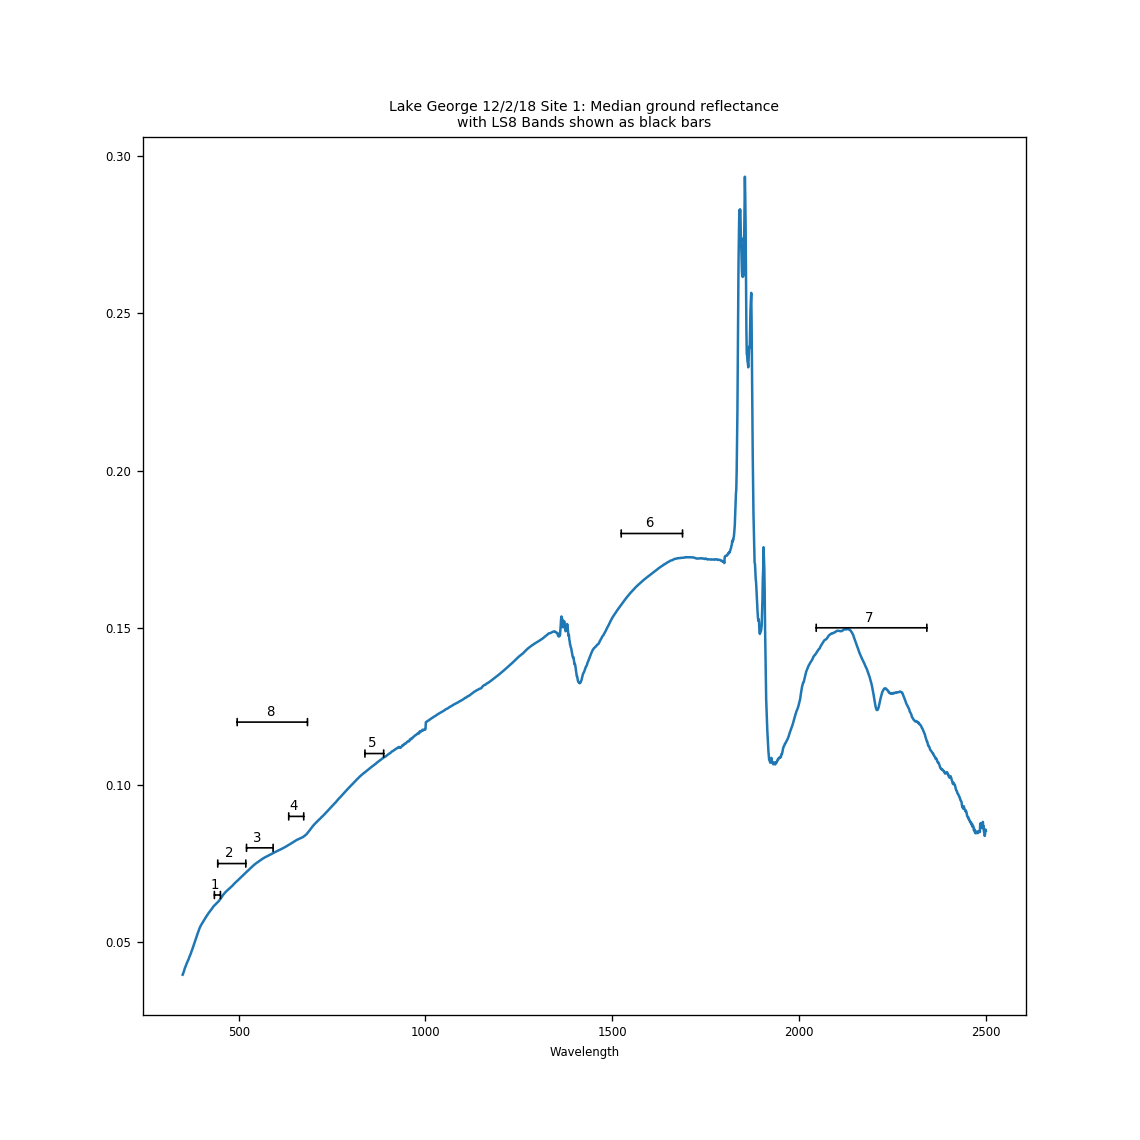

In [25]:
med = all_refls.median(axis=1)
all_refls['Median'] = med
ax3 = all_refls.plot(y='Median', legend=False, title=field_site+" "+field_date+" "+site_number+': Median ground reflectance\nwith LS8 Bands shown as black bars', figsize=(9.5, 9.5))

# for LS8: 
y_cord = [0.065, 0.075, 0.08, 0.09, 0.11, 0.18, 0.15, 0.12]
# for Sentinel 2b:
#y_cord = [0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.15]

for i in range(len(band_min)):
    plt.annotate('', xy = (band_min[i], y_cord[i]),  xycoords = 'data', \
        xytext = (band_max[i], y_cord[i]), textcoords = 'data',\
        arrowprops=dict(edgecolor='black', arrowstyle = '|-|, widthA=0.3, widthB=0.3'))
    plt.text((band_max[i]+band_min[i]-35)/2, y_cord[i]+0.002, i+1, fontsize=8)

plt.savefig(output+'Fig10_BandWavelengths.png')

In [26]:
print(ground_bands['date_saved'][0])
print(ground_bands['Latitude'].min(), ground_bands['Latitude'].max(),
      ground_bands['Longitude'].min(), ground_bands['Longitude'].max())


2018-02-12 00:27:06
-35.09372833333333 -35.09316833333333 149.46273166666666 149.46332833333332


In [27]:
query = {
         'time': ('2018-02-10', '2018-02-12'),
         'lat': (-35.0938, -35.0931),
         'lon': (149.4625, 149.4634),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
        }
sat_array = dc.load(product='ls8_nbar_albers', **query)
sat_rgb = dc.load(product='ls8_nbar_albers', measurements=['red', 'green', 'blue'], **query)

In [28]:
sat_array.coords['time']

<xarray.DataArray 'time' (time: 1)>
array(['2018-02-11T23:50:07.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-02-11T23:50:07
Attributes:
    units:    seconds since 1970-01-01 00:00:00

<IPython.core.display.Javascript object>


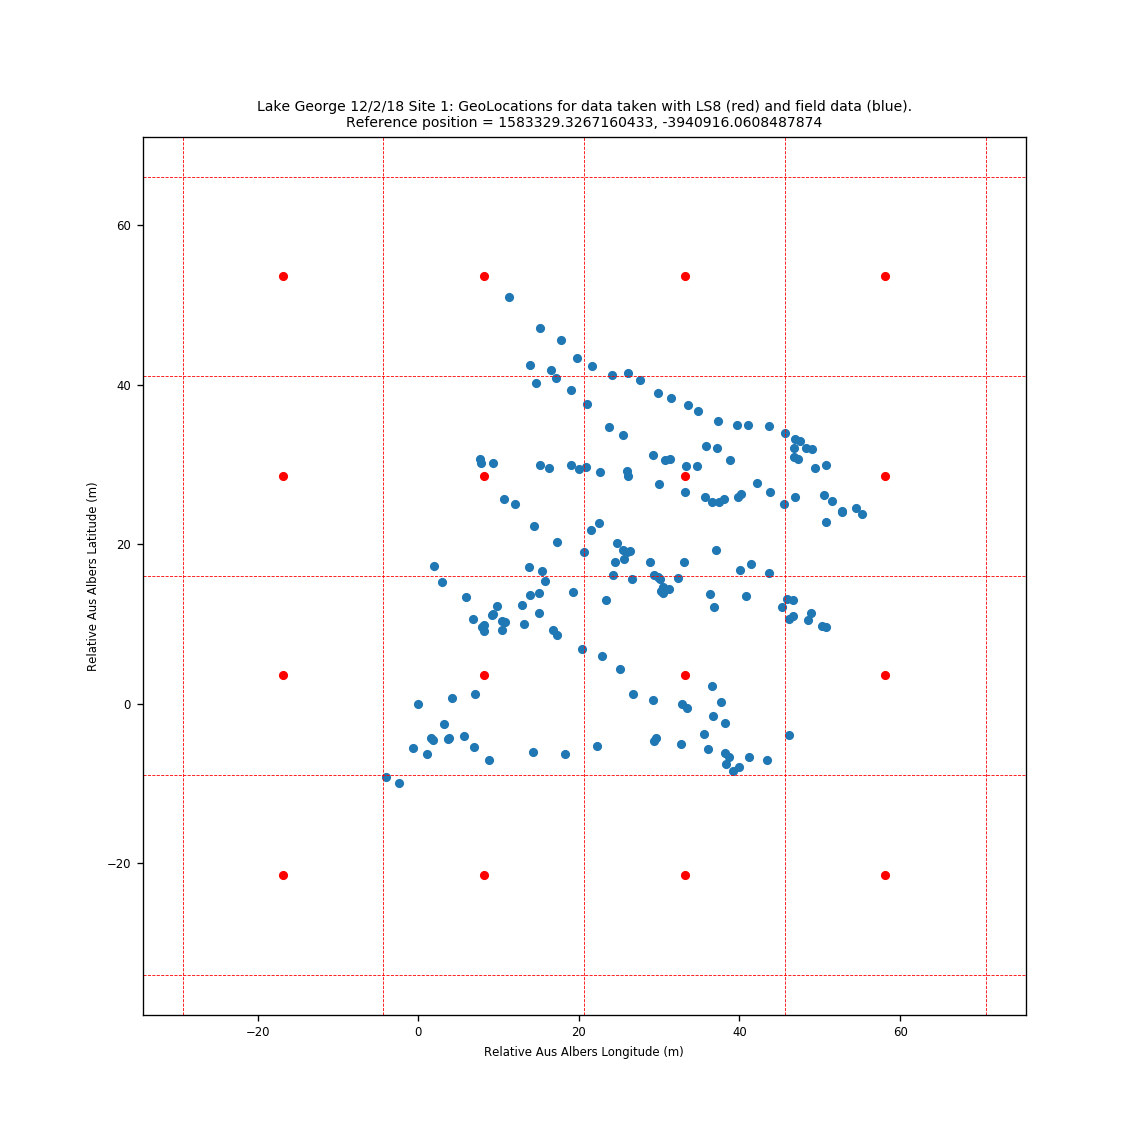

In [29]:
wgs_84 = pyproj.Proj(init='epsg:4326')
aus_albers = pyproj.Proj(init='epsg:3577')

#for i in range(len(data.x)):
#    for j in range(len(data.y)):
#        print(float(data.x[i]-data.x[0]), float(data.y[j]-data.y[0]))
        #print(pyproj.transform(aus_albers, wgs_84, float(data.x[i]), float(data.y[j])))
        
#float(data.swir2.mean())

xloc = [pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][i], ground_brdf['Latitude'][i]) for i in range(len(ground_brdf))]

    
relxloc = [(xloc[i][0]-xloc[0][0], xloc[i][1]-xloc[0][1]) for i in range(len(ground_brdf))]

satloc = [[0 for x in range(2)] for y in range(len(sat_array.x)*(len(sat_array.y)))]
count=0
for i in range(len(sat_array.x)):
    for j in range(len(sat_array.y)):
        satloc[count][0] = float(sat_array.x[i]-xloc[0][0])
        satloc[count][1] = float(sat_array.y[j]-xloc[0][1])
        count+=1

          
satloc_df = pd.DataFrame(satloc)
satloc_df

def gridlines(satloc_df):
    axx.axhline(satloc_df[1].unique()[0]+12.5, linestyle='--', color='r', linewidth=0.5)
    for i in range(len(satloc_df[1].unique())):
        axx.axhline(satloc_df[1].unique()[0]-(12.5+(25*i)), linestyle='--', color='r', linewidth=0.5)

    axx.axvline(satloc_df[0].unique()[0]-12.5, linestyle='--', color='r', linewidth=0.5)
    for i in range(len(satloc_df[0].unique())):
        axx.axvline(satloc_df[0].unique()[0]+(12.5+(25*i)), linestyle='--', color='r', linewidth=0.5)


rr = pd.DataFrame(relxloc)
axx = rr.plot.scatter(0,1)
satloc_df.plot.scatter(0,1, ax=axx, color='red', figsize=(9.5, 9.5), title=field_site+" "+field_date+" "+site_number+': GeoLocations for data taken with LS8 (red) and field data (blue).\nReference position = '+str(xloc[0][0])+', '+str(xloc[0][1]))
axx.set_xlabel("Relative Aus Albers Longitude (m)")
axx.set_ylabel("Relative Aus Albers Latitude (m)")

gridlines(satloc_df)

plt.savefig(output+'Fig11_SatFieldLocations.png')

In [30]:
for i in range(len(ground_brdf)):
    ground_brdf['Xalbers'], ground_brdf['Yalbers'] = pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][i], ground_brdf['Latitude'][i])
    
print(ground_brdf['Xalbers'][4], ground_brdf['Yalbers'][4])

pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][4], ground_brdf['Latitude'][4])

1583380.1056775178 -3940886.182505081


(1583330.8734117942, -3940920.3902580906)

In [31]:
field_rgb = sat_rgb.astype(float)

for i in range(len(sat_rgb.x)):
    for j in range(len(sat_rgb.y)):
        count = 0
        cum2, cum3, cum4 = 0, 0, 0
        for k in range(len(xloc)):
            if (sat_rgb.x[i]-12.5 < xloc[k][0] < sat_rgb.x[i]+12.5) and (sat_rgb.y[j]-12.5 < xloc[k][1] < sat_rgb.y[j]+12.5):
                cum2 = cum2+ground_brdf.iloc[k]['band2']
                cum3 = cum3+ground_brdf.iloc[k]['band3']
                cum4 = cum4+ground_brdf.iloc[k]['band4']
                count=count+1
        try:
            field_rgb.blue[0][j][i] = cum2/count
            field_rgb.green[0][j][i] = cum3/count
            field_rgb.red[0][j][i] = cum4/count

        except ZeroDivisionError:
            field_rgb.blue[0][j][i] = np.nan
            field_rgb.green[0][j][i] = np.nan
            field_rgb.red[0][j][i] = np.nan


<IPython.core.display.Javascript object>


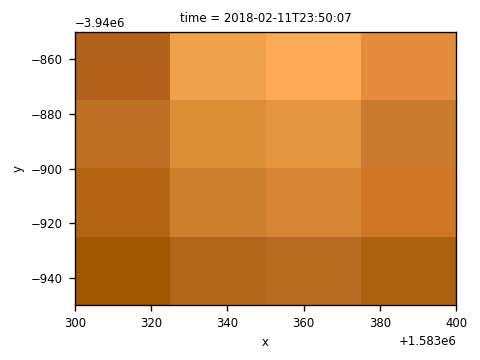

<IPython.core.display.Javascript object>


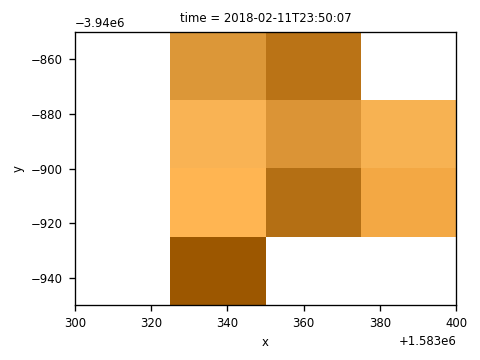

In [32]:
fake_saturation = 10000
srgb = sat_rgb.to_array(dim='color')
srgb = srgb.transpose(*(srgb.dims[1:]+srgb.dims[:1]))  # make 'color' the last dimension
srgb = srgb.where((srgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
srgb /= fake_saturation  # scale to [0, 1] range for imshow

srgb.plot.imshow(x=sat_rgb.crs.dimensions[1], y=sat_rgb.crs.dimensions[0],
                col='time', aspect=1)

plt.savefig(output+'Fig12_LS8_rgb.png')

fake_saturation = 1
frgb = field_rgb.to_array(dim='color')
frgb = frgb.transpose(*(frgb.dims[1:]+frgb.dims[:1]))  # make 'color' the last dimension
frgb = frgb.where((frgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
frgb /= fake_saturation  # scale to [0, 1] range for imshow


frgb.plot.imshow(x=field_rgb.crs.dimensions[1], y=field_rgb.crs.dimensions[0],
                col='time', add_colorbar=True)
plt.savefig(output+'Fig13_Field_rgb.png')

In [33]:
#
# TEST QUERY FOR SENTINEL 2 DATA
#
# dc2 = datacube.Datacube(config='/home/547/aw3463/sentinel2.config')
#
#query = {
#        'lat': (-35.25, -35.35),
#        'lon': (149.05, 149.17),
#        'output_crs': 'EPSG:3577',
#        'resolution': (-10, 10),
#        'time':('2017-10-01', '2018-05-15')
#        }
#
#canberra = dc2.load(product='s2b_ard_granule', **query)
#
#canberra

In [34]:
sat_bands = ['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2']


In [35]:
field_array = sat_array.astype(float)

for i in range(len(sat_array.x)):
    for j in range(len(sat_array.y)):
        count = 0
        cum1, cum2, cum3, cum4, cum5, cum6, cum7 = 0,0,0,0,0,0,0
        for k in range(len(xloc)):
            if (sat_array.x[i]-12.5 < xloc[k][0] < sat_array.x[i]+12.5) and (sat_array.y[j]-12.5 < xloc[k][1] < sat_array.y[j]+12.5):
                cum1 = cum1+ground_brdf.iloc[k]['band1']
                cum2 = cum2+ground_brdf.iloc[k]['band2']
                cum3 = cum3+ground_brdf.iloc[k]['band3']
                cum4 = cum4+ground_brdf.iloc[k]['band4']
                cum5 = cum5+ground_brdf.iloc[k]['band5']
                cum6 = cum6+ground_brdf.iloc[k]['band6']
                cum7 = cum7+ground_brdf.iloc[k]['band7']
                count=count+1
        try:
            field_array.coastal_aerosol[0][j][i] = cum1/count            
            field_array.blue[0][j][i] = cum2/count
            field_array.green[0][j][i] = cum3/count
            field_array.red[0][j][i] = cum4/count
            field_array.nir[0][j][i] = cum5/count
            field_array.swir1[0][j][i] = cum6/count
            field_array.swir2[0][j][i] = cum7/count
        except ZeroDivisionError:
            field_array.coastal_aerosol[0][j][i] = np.nan
            field_array.blue[0][j][i] = np.nan
            field_array.green[0][j][i] = np.nan
            field_array.red[0][j][i] = np.nan
            field_array.nir[0][j][i] = np.nan
            field_array.swir1[0][j][i] = np.nan
            field_array.swir2[0][j][i] = np.nan

In [36]:
#newarr = 100*((sat_array/10000)-field_array)/field_array
#plt.figure()
#field_rgb.red.plot()
#plt.savefig(output+'Fig14_FieldRedBand.png')
#plt.figure()
#sat_rgb.red.plot()
#plt.savefig(output+'Fig15_SatRedBand.png')


<IPython.core.display.Javascript object>


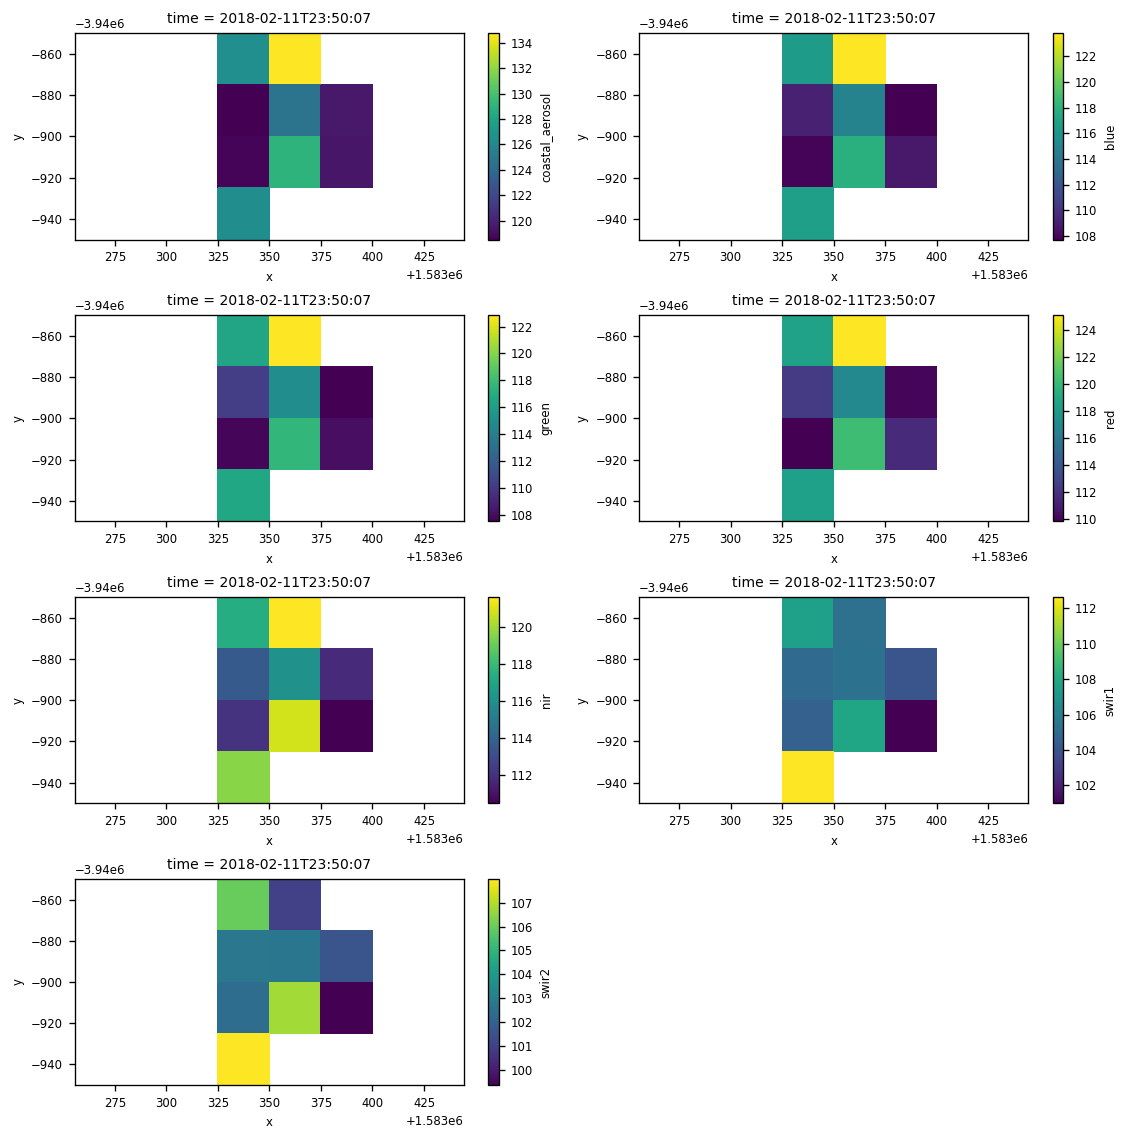

In [37]:
newarr = 100*((sat_array/10000)/field_array)
#fig, axes = plt.subplots(nrows=1, ncols=2)
plt.figure(figsize=(9.5, 9.5))
plt.subplot(421)
plt.axis('equal')
newarr.coastal_aerosol.plot()
plt.subplot(422)
plt.axis('equal')
newarr.blue.plot()
plt.subplot(423)
plt.axis('equal')
newarr.green.plot()
plt.subplot(424)
plt.axis('equal')
newarr.red.plot()
plt.subplot(425)
plt.axis('equal')
newarr.nir.plot()
plt.subplot(426)
plt.axis('equal')
newarr.swir1.plot()
plt.subplot(427)
plt.axis('equal')
newarr.swir2.plot()
plt.tight_layout()
plt.axis('equal')
plt.savefig(output+'Fig14_RatioSatOverFieldData.png')

In [38]:
# ground_bands: all field data, segmented into 8 band measurements
# data: LS8 data for field area, with information on the first 7 bands


#
# The following will print out ratios of LS8/field averages per band
#
#print(float(data.coastal_aerosol.mean()/ground_bands['band1'].mean()))
#print(float(data.blue.mean()/ground_bands['band2'].mean()))
#print(float(data.green.mean()/ground_bands['band3'].mean()))
#print(float(data.red.mean()/ground_bands['band4'].mean()))
#print(float(data.nir.mean()/ground_bands['band5'].mean()))
#print(float(data.swir1.mean()/ground_bands['band6'].mean()))
#print(float(data.swir2.mean()/ground_bands['band7'].mean()))

#sat_array.blue.std()

data_array = np.array([['','LS8_mean','LS8_SD', 'Field_mean', 'Field_SD'],
                ['Band1', float(sat_array.coastal_aerosol.mean()/10000), float(sat_array.coastal_aerosol.std()/10000), float(ground_bands['band1'].mean()), float(ground_bands['band1'].std())],
                ['Band2', float(sat_array.blue.mean()/10000), float(sat_array.blue.std()/10000), float(ground_bands['band2'].mean()), float(ground_bands['band2'].std())],
                ['Band3', float(sat_array.green.mean()/10000), float(sat_array.green.std()/10000), float(ground_bands['band3'].mean()), float(ground_bands['band3'].std())],
                ['Band4', float(sat_array.red.mean()/10000), float(sat_array.red.std()/10000), float(ground_bands['band4'].mean()), float(ground_bands['band4'].std())],
                ['Band5', float(sat_array.nir.mean()/10000), float(sat_array.nir.std()/10000), float(ground_bands['band5'].mean()), float(ground_bands['band5'].std())],
                ['Band6', float(sat_array.swir1.mean()/10000), float(sat_array.swir1.std()/10000), float(ground_bands['band6'].mean()), float(ground_bands['band6'].std())],
                ['Band7', float(sat_array.swir2.mean()/10000), float(sat_array.swir2.std()/10000), float(ground_bands['band7'].mean()), float(ground_bands['band7'].std())],
                ])
                
stat_df = pd.DataFrame(data=data_array[1:,1:],
                  index=data_array[1:,0],
                  columns=data_array[0,1:])

stat_df['LS8_SD/mean (%)'] = 100*stat_df['LS8_SD'].astype(float)/stat_df['LS8_mean'].astype(float)
stat_df['Field_SD/mean (%)'] = 100*stat_df['Field_SD'].astype(float)/stat_df['Field_mean'].astype(float)
stat_df['LS8/Field'] = stat_df['LS8_mean'].astype(float)/stat_df['Field_mean'].astype(float) 

stat_df
#stat_df['LS8/Field'].std()/stat_df['LS8/Field'].mean()*100

,LS8_mean,LS8_SD,Field_mean,Field_SD,LS8_SD/mean (%),Field_SD/mean (%),LS8/Field
Band1,0.07050625,0.0023020286569675886,0.06321859031996228,0.00638859285780678,3.264999,10.105560,1.115277
Band2,0.07,0.0023038012067016543,0.06848318043354126,0.006877758592881715,3.291145,10.042989,1.022149
Band3,0.0784375,0.0024753471978694224,0.07664564427404098,0.007626016604265751,3.155821,9.949706,1.023378
Band4,0.08669375,0.0026545877151640707,0.08280144359150246,0.00808739466192312,3.062029,9.767215,1.047008
Band5,0.11608125,0.0025090383491489323,0.10739820762912748,0.009387828189376066,2.161450,8.741140,1.080849
Band6,0.16763125,0.0019757020113114225,0.1682561163901262,0.01154635295426631,1.178600,6.862367,0.996286
Band7,0.13066875,0.0021230045778330296,0.13618043823288362,0.01032653338135017,1.624722,7.582979,0.959527


In [39]:
fstat_df = stat_df.astype(float)
#fstat_df['Field_mean'] = fstat_df['Field_mean']*1.5

<IPython.core.display.Javascript object>


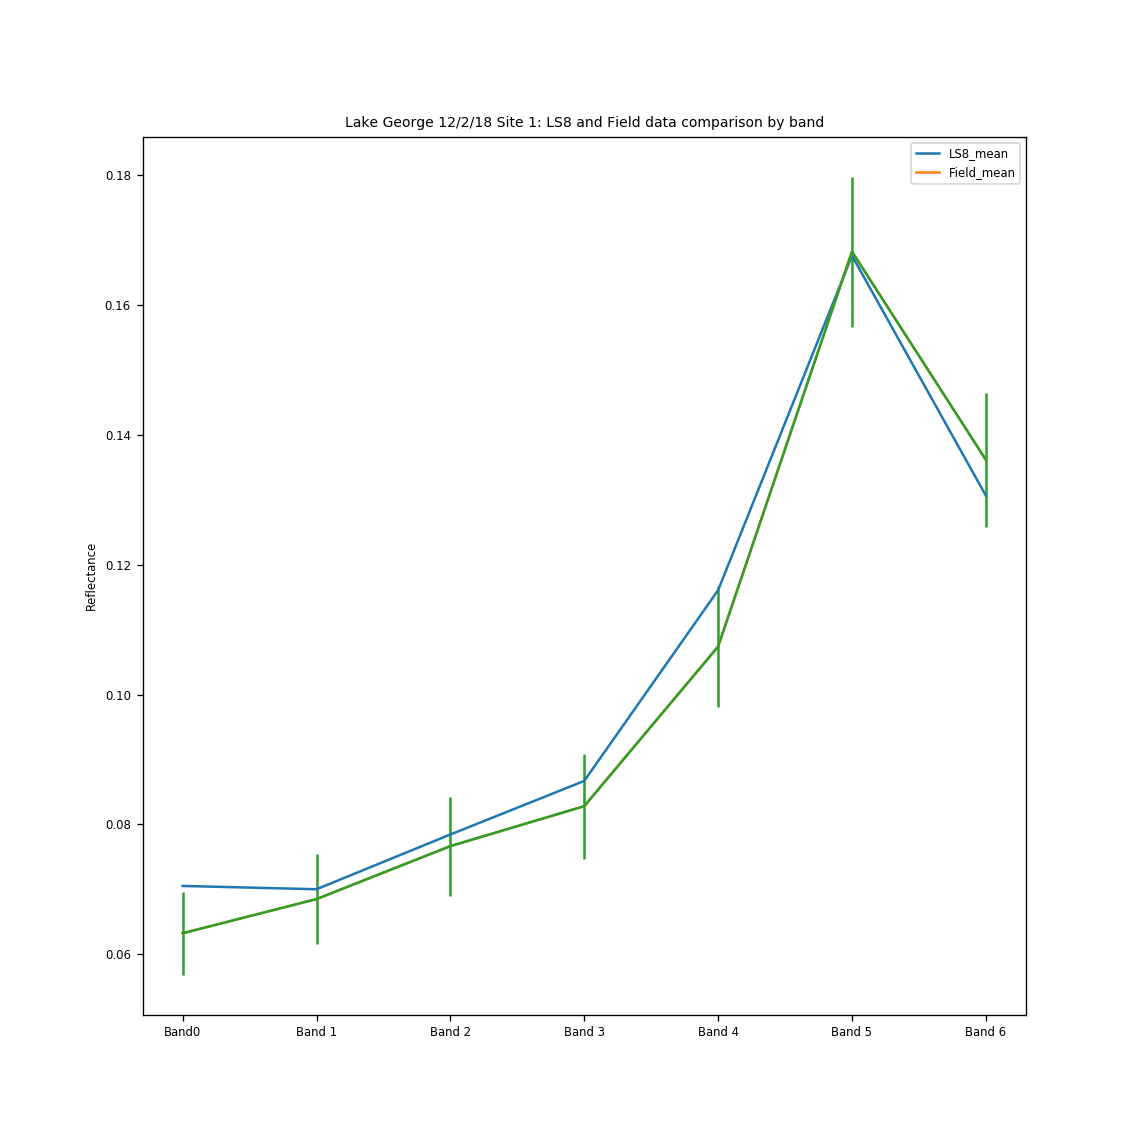

In [40]:
a3x = fstat_df.plot(x=fstat_df.index, y='LS8_mean')
fstat_df.plot(y='Field_mean', ax=a3x, title=field_site+" "+field_date+" "+site_number+': LS8 and Field data comparison by band', figsize=(9.5, 9.5))
a3x.set_ylabel('Reflectance')
plt.errorbar(x=fstat_df.index, y=fstat_df['Field_mean'], yerr=fstat_df['Field_SD'])
a3x.set_xticklabels(['Band0','Band 1','Band 2','Band 3','Band 4','Band 5','Band 6', 'Band 7'])
plt.savefig(output+'Fig15_LS8FieldBandCompare.png')

<IPython.core.display.Javascript object>


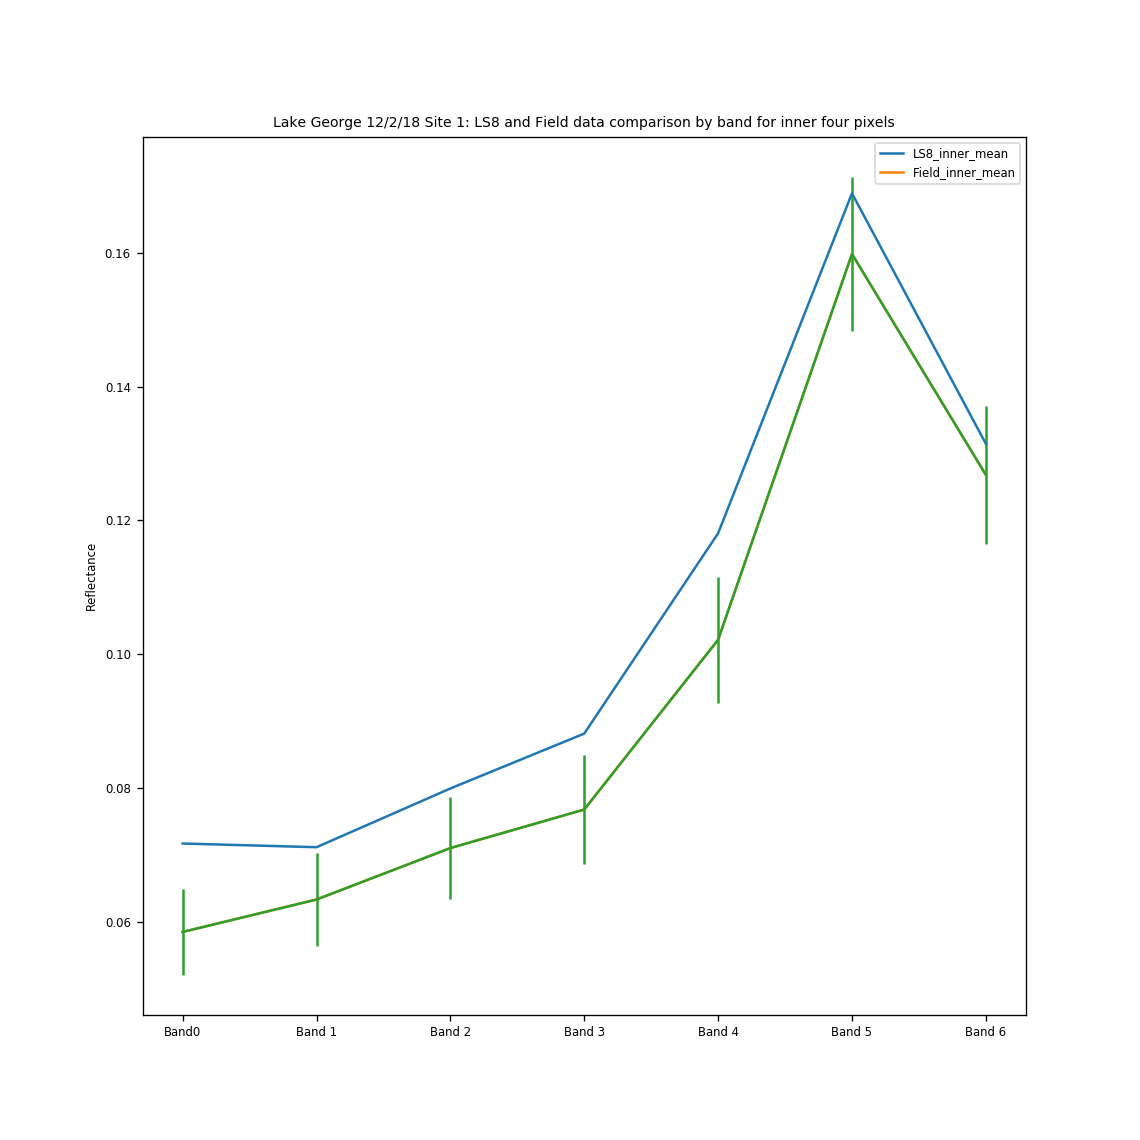

In [41]:
inner_array = np.array([['', 'LS8_inner_mean', 'Field_inner_mean'],
                        ['Band1', float(sat_array.coastal_aerosol[0][1:3,1:3].mean()/10000), float(field_array.coastal_aerosol[0][1:3,1:3].mean())],
                        ['Band2', float(sat_array.blue[0][1:3,1:3].mean()/10000), float(field_array.blue[0][1:3,1:3].mean())],
                        ['Band3', float(sat_array.green[0][1:3,1:3].mean()/10000), float(field_array.green[0][1:3,1:3].mean())],
                        ['Band4', float(sat_array.red[0][1:3,1:3].mean()/10000), float(field_array.red[0][1:3,1:3].mean())],
                        ['Band5', float(sat_array.nir[0][1:3,1:3].mean()/10000), float(field_array.nir[0][1:3,1:3].mean())],
                        ['Band6', float(sat_array.swir1[0][1:3,1:3].mean()/10000), float(field_array.swir1[0][1:3,1:3].mean())],
                        ['Band7', float(sat_array.swir2[0][1:3,1:3].mean()/10000), float(field_array.swir2[0][1:3,1:3].mean())],
                       ])

inner_df = pd.DataFrame(data=inner_array[1:,1:],
                  index=inner_array[1:,0],
                  columns=inner_array[0,1:])

inner_df['Field_SD'] = fstat_df['Field_SD']

finner_df = inner_df.astype(float)

a4x = finner_df.plot(x=finner_df.index, y='LS8_inner_mean')
finner_df.plot(y='Field_inner_mean', ax=a4x, title=field_site+" "+field_date+" "+site_number+': LS8 and Field data comparison by band for inner four pixels', figsize=(9.5, 9.5))
a4x.set_ylabel('Reflectance')
plt.errorbar(x=finner_df.index, y=finner_df['Field_inner_mean'], yerr=finner_df['Field_SD'])
a4x.set_xticklabels(['Band0','Band 1','Band 2','Band 3','Band 4','Band 5','Band 6', 'Band 7'])
plt.savefig(output+'Fig16_InnerLS8FieldBandCompare.png')

<IPython.core.display.Javascript object>


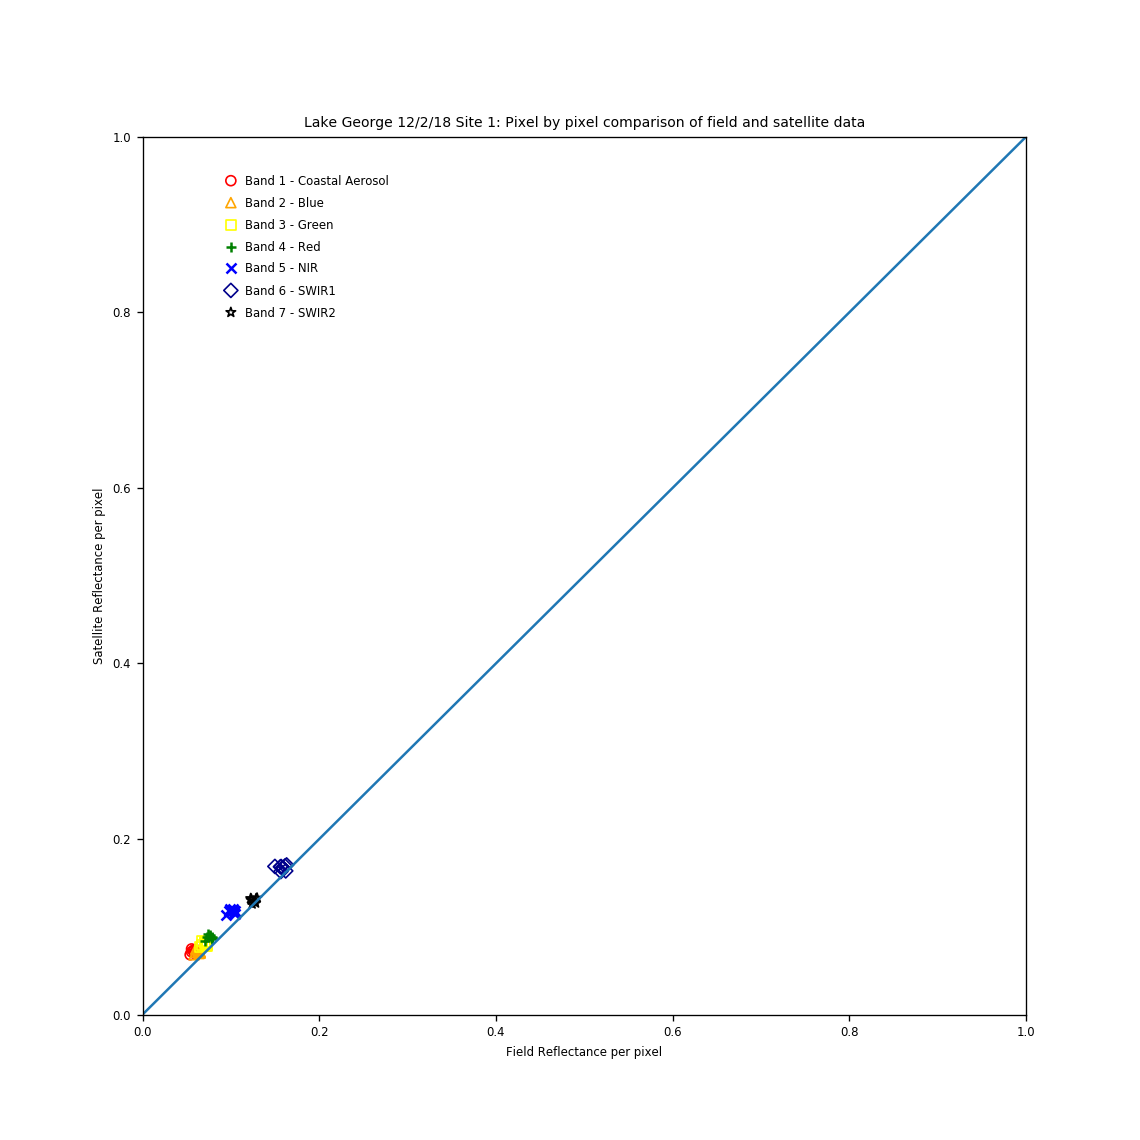

In [44]:
plt.figure(figsize=(9.5, 9.5))
plt.xlim(0, 1)
plt.ylim(0, 1)
p1, p2 = [-1, 2], [-1, 2]
plt.plot(p1, p2, marker='o')
plt.xlabel('Field Reflectance per pixel')
plt.ylabel('Satellite Reflectance per pixel')
plt.title(field_site+" "+field_date+" "+site_number+": Pixel by pixel comparison of field and satellite data")

plt.scatter(field_array.coastal_aerosol[0], sat_array.coastal_aerosol[0]/10000, marker='o', facecolors='none', edgecolors='red')
plt.scatter(field_array.blue[0], sat_array.blue[0]/10000, marker='^', facecolors='none', edgecolors='orange')
plt.scatter(field_array.green[0], sat_array.green[0]/10000, marker='s', facecolors='none', edgecolors='yellow')
plt.scatter(field_array.red[0], sat_array.red[0]/10000, marker='+', color='green')
plt.scatter(field_array.nir[0], sat_array.nir[0]/10000, marker='x', color='blue')
plt.scatter(field_array.swir1[0], sat_array.swir1[0]/10000, marker='D', facecolors='none', edgecolors='darkblue')
plt.scatter(field_array.swir2[0], sat_array.swir2[0]/10000, marker='*', facecolors='none', edgecolors='black')

plt.scatter(0.1, 0.950, marker='o', facecolors='none', edgecolors='red')
plt.scatter(0.1, 0.925, marker='^', facecolors='none', edgecolors='orange')
plt.scatter(0.1, 0.900, marker='s', facecolors='none', edgecolors='yellow')
plt.scatter(0.1, 0.875, marker='+', color='green')
plt.scatter(0.1, 0.850, marker='x', color='blue')
plt.scatter(0.1, 0.825, marker='D', facecolors='none', edgecolors='darkblue')
plt.scatter(0.1, 0.800, marker='*', facecolors='none', edgecolors='black')

plt.figtext(0.215, 0.838, "Band 1 - Coastal Aerosol")
plt.figtext(0.215, 0.818, "Band 2 - Blue")
plt.figtext(0.215, 0.799, "Band 3 - Green")
plt.figtext(0.215, 0.780, "Band 4 - Red")
plt.figtext(0.215, 0.761, "Band 5 - NIR")
plt.figtext(0.215, 0.741, "Band 6 - SWIR1")
plt.figtext(0.215, 0.722, "Band 7 - SWIR2")
plt.savefig(output+'Fig17_PixelByPixelComparison.png')